In [1]:
import os
import numpy as np
import pandas as pd 

# Loading data

In [2]:
path2data = "/kaggle/input/brain-tumor-object-detection-datasets/axial_t1wce_2_class/"
path2labels_train = os.path.join(path2data, "labels/train") 
path2labels_test = os.path.join(path2data, "labels/test")
filenames_labels_train = os.listdir(path2labels_train)
filenames_labels_test = os.listdir(path2labels_test) 

In [3]:
train_labels = {
    "ID": [],
    "class": [],
    "x_cent": [],
    "y_cent": [],
    "width": [],
    "height": []
}
test_labels = {
    "ID": [],
    "class": [],
    "x_cent": [],
    "y_cent": [],
    "width": [],
    "height": []
}
for train in filenames_labels_train:
    path_train = os.path.join(path2labels_train, train)
    with open(path_train, "r") as train_file:
        content = train_file.read()
        train_labels["ID"].append(train[:-4])
        train_labels["class"].append(int(content.split()[0]))
        train_labels["x_cent"].append(float(content.split()[1]))
        train_labels["y_cent"].append(float(content.split()[2]))
        train_labels["width"].append(float(content.split()[3]))
        train_labels["height"].append(float(content.split()[4]))
for test in filenames_labels_test:
    path_test = os.path.join(path2labels_test, test)
    with open(path_test, "r") as test_file:
        content = test_file.read()
        test_labels["ID"].append(test[:-4])
        test_labels["class"].append(int(content.split()[0]))
        test_labels["x_cent"].append(float(content.split()[1]))
        test_labels["y_cent"].append(float(content.split()[2]))
        test_labels["width"].append(float(content.split()[3]))
        test_labels["height"].append(float(content.split()[4]))


In [4]:
train_labels_df = pd.DataFrame(train_labels)
test_labels_df = pd.DataFrame(test_labels)
test_labels_df.head()

,ID,class,x_cent,y_cent,width,height
0,00053_277,0,0.583920,0.418427,0.062207,0.071596
1,00072_73,0,0.650822,0.540493,0.191315,0.198357
2,00044_118,0,0.680751,0.555751,0.058685,0.048122
3,00088_137,0,0.421362,0.680164,0.157277,0.188967
4,00022_77,0,0.396714,0.607394,0.171362,0.172535


In [5]:
os.mkdir("/kaggle/working/labels/")
train_labels_df.to_csv("/kaggle/working/labels/" + "train_labels.csv")
test_labels_df.to_csv("/kaggle/working/labels/" + "test_labels.csv") 

In [6]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pylab as plt
np.random.seed(2023)
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision

In [7]:
class CoordinateConverter:
    def __init__(self, image_size=(224, 224), feature_map_size=(7, 7)):
        self.image_size = image_size
        self.feature_map_size = feature_map_size

    def image_to_feature(self, x1, y1, x2, y2):
        """
        Converts the coordinates from image space to feature space.

        Inputs:
            x1, y1, x2, y2 (int): Coordinates of the bounding box in image space.

        Output:
            List: Coordinates of the given bounding box in feature space.
        """
        image_width, image_height = self.image_size
        feature_width, feature_height = self.feature_map_size

        stride_x = image_width / (feature_width)
        stride_y = image_height / (feature_height)

        feature_x1 = x1 / stride_x
        feature_y1 = y1 / stride_y
        feature_x2 = x2 / stride_x
        feature_y2 = y2 / stride_y

        return [feature_x1, feature_y1, feature_x2, feature_y2]

    def feature_to_image(self, feature_x1, feature_y1, feature_x2, feature_y2):
        """
        Converts the coordinates from feature space to image space.

        Inputs:
            feature_x1, feature_y1, feature_x2, feature_y2 (int): Coordinates of the bounding box in feature space.

        Output:
            List: Coordinates of the given bounding box in image space.
        """
        image_width, image_height = self.image_size
        feature_width, feature_height = self.feature_map_size

        stride_x = image_width / (feature_width )
        stride_y = image_height / (feature_height)

        x1 = feature_x1 * stride_x
        y1 = feature_y1 * stride_y
        x2 = feature_x2 * stride_x
        y2 = feature_y2 * stride_y

        return [x1, y1, x2, y2]
    
convertor=CoordinateConverter()

In [8]:
class TumorDataset(Dataset):
    def __init__(self, transform=None,train=True):
        self.transform = transform
        self.train=train
        if self.train:
            self.data=train_labels_df 
        else:
            self.data=test_labels_df
        

    def __len__(self):
        return len(self.data)
    
    def generate_anchor_boxes(self,feature_map_size, anchor_scales, anchor_ratios,stride):
        '''Generates anchor boxes given anchor scales, anchor ratios and stride(stride: 1 unit of lenfth or breadth in the feature space is equal to how many units of lenght or breadth in the image space)
           Inputs: tuple:feature map size
                   list:anchor_scales
                   list:anchor_ratios
                   int: stride
           Output: numpy array: anchor boxes (feature_map_size[0] x feature_map_size[1] x number of anchor boxes per location x 4) '''
        
        num_anchors = len(anchor_scales) * len(anchor_ratios)
        anchors = np.zeros((feature_map_size[0], feature_map_size[1], num_anchors, 4))  # (H, W, num_anchors, 4)

        for i in range(feature_map_size[0]):
            for j in range(feature_map_size[1]):
                for k, scale in enumerate(anchor_scales):
                    for l, ratio in enumerate(anchor_ratios):
                        # Calculate anchor box coordinates
                        w = scale * np.sqrt(ratio) # ratio= width/height
                        h = scale / np.sqrt(ratio) #1/ratio =height/width
                        x1 = j * stride - w / 2
                        y1 = i * stride - h / 2
                        x2 = j * stride + w / 2
                        y2 = i * stride + h / 2
                        
                        anchors[i, j, k * len(anchor_ratios) + l] = convertor.image_to_feature(x1, y1, x2, y2)

        return anchors

    def assign_anchor_labels(self,anchors, gt_boxes, pos_iou_thresh=0.7, neg_iou_thresh=0.3, ignore_thresh=0.4):
        '''Labels the anchor boxes as positive, nagative and ignore boxes based on iou with ground truth box.'''
        
        num_anchors = np.prod(anchors.shape[:3])
        anchors_reshaped = anchors.reshape(num_anchors, 4)
        gt_boxes=torch.tensor(gt_boxes)
        num_gt_boxes = 1
        gt_boxes_reshaped = gt_boxes.reshape(num_gt_boxes, 4)
        iou = self.box_iou(torch.tensor(anchors_reshaped), gt_boxes_reshaped).numpy()


        #iou = box_iou(torch.tensor(anchors.reshape(-1, 4)), torch.tensor(gt_boxes)).numpy() # reshapes to size (h*w*number of anchor boxes , 4)
        iou = iou.reshape(anchors.shape[:3]+ (-1,) ) 
        labels = np.zeros(anchors.shape[:3], dtype=int)

    
        max_iou = np.amax(iou, axis=3)
        argmax_iou = np.argmax(iou, axis=3)
        labels[max_iou < neg_iou_thresh] = 0  # Negative label
        labels[max_iou >= pos_iou_thresh] = 1  # Positive label
        labels[np.logical_and(max_iou >=neg_iou_thresh, max_iou < pos_iou_thresh)] = -1  # Ignore label

        # Set positive label for anchors with the highest IoU for each ground-truth box
        for gt_idx in range(gt_boxes.shape[0]):
            if iou.shape[3] == 1:
                anchor_idx = np.unravel_index(np.argmax(iou), iou.shape[:3])
            else:
                anchor_idx = np.unravel_index(np.argmax(iou[:, :, :, gt_idx]), iou.shape[:3])

            labels[anchor_idx] = 1
    
        return labels 
    
    def generate_regression_targets(self,anchors, gt_boxes, labels):
        num_anchors = len(anchors)
        regression_targets = np.zeros((num_anchors, 4), dtype= float)

        gt_boxes=torch.tensor(gt_boxes).reshape(1,4)

        for i in range(num_anchors):
            if labels[i] == 1:  # Positive anchor box
                anchor = anchors[i]
                gt_box = gt_boxes[np.argmax(self.box_iou(torch.tensor(anchor.reshape(-1, 4)), gt_boxes))]  # Corresponding ground-truth box
                regression_targets[i] = self.compute_regression_target(anchor, gt_box)  # Calculate regression targets

        return regression_targets
    
    def compute_regression_target(self,anchor, gt_box):
        """
        Compute bounding box regression targets (deltas) between an anchor box and a ground-truth bounding box.
        """
        ax1, ay1, ax2, ay2 = anchor
        gx1, gy1, gx2, gy2 = gt_box
        
        eps = 1e-10
        width_anchor = max(np.abs(ax2 - ax1), eps)
        height_anchor = max(np.abs(ay2 - ay1), eps)
        width_gt = max(np.abs(gx2 - gx1),eps)
        height_gt = max(np.abs(gy2 - gy1),eps)
       
        
        dx = (gx1 - ax1) / width_anchor
        dy = (gy1 - ay1) / height_anchor
        dw = np.log(width_gt / width_anchor)
        dh = np.log(height_gt / height_anchor) 
    
        return np.array([dx, dy, dw, dh], dtype=float)
    
    def box_iou(self,anchors, gt_box):
        """
        Calculate IoU between anchor boxes and a single ground truth box.

        Inputs:
            anchors (torch.Tensor): Anchor boxes of shape (7, 7, num_anchors, 4) containing (x1, y1, x2, y2) coordinates.(7x7 is the feature map size).
            gt_box (torch.Tensor): Ground truth box of shape (1, 4) containing (x1, y1, x2, y2) coordinates.

        Outputs:
            Tensor: IoU between each anchor box and the ground truth box, shaped (7, 7, num_anchors, 1).
        """

        anchor_x1 = anchors[..., 0]
        anchor_y1 = anchors[..., 1]
        anchor_x2 = anchors[..., 2]
        anchor_y2 = anchors[..., 3]

        gt_x1, gt_y1, gt_x2, gt_y2 = gt_box[0]


        inter_x1 = torch.max(anchor_x1, gt_x1)
        inter_y1 = torch.max(anchor_y1, gt_y1)
        inter_x2 = torch.min(anchor_x2, gt_x2)
        inter_y2 = torch.min(anchor_y2, gt_y2)

        
        inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(inter_y2 - inter_y1, min=0) #intersection area


        anchor_area = (anchor_x2 - anchor_x1) * (anchor_y2 - anchor_y1)
        gt_area = (gt_x2 - gt_x1) * (gt_y2 - gt_y1)

    
        union_area = anchor_area + gt_area - inter_area


        iou = inter_area / (union_area + 1e-6)  
        return iou.view(-1, 1)
    
    def generate_rpn_training_data(self,image_shape, gt_boxes, anchor_scales, anchor_ratios, stride=32, pos_iou_thresh=0.5, neg_iou_thresh=0.1, ignore_thresh=0.4):
        """
        Generate training data for the Region Proposal Network (RPN) in our Faster R-CNN.

        Inputs:
            image_shape (tuple): Shape of the input image in the format (height, width).
            gt_boxes (numpy array): Ground truth bounding boxes of shape (num_gt_boxes, 4) in format (x1, y1, x2, y2).
            anchor_scales (list): List of scales for anchor boxes.
            anchor_ratios (list): List of aspect ratios for anchor boxes.
            stride (int): Stride of the feature map.
            pos_iou_thresh (float): IoU threshold for positive anchors.
            neg_iou_thresh (float): IoU threshold for negative anchors.
            ignore_thresh (float): IoU threshold for anchors to be ignored.

        Outputs:
            numpy array: Anchor boxes of shape (H, W, num_anchors, 4).
            numpy array: Anchor labels of shape (H, W, num_anchors) where 0 represents background, 1 represents foreground, and -1 represents ignore.
            numpy.array: Regression targets of shape (H, W, num_anchors, 4).
        """

        feature_map_size = (image_shape[0] // stride, image_shape[1] // stride)
        anchors = self.generate_anchor_boxes(feature_map_size, anchor_scales, anchor_ratios,stride=stride)
        gt_boxes=convertor.image_to_feature(*gt_boxes)

        labels = self.assign_anchor_labels(anchors, gt_boxes, pos_iou_thresh, neg_iou_thresh, ignore_thresh)


        regression_targets = np.zeros((feature_map_size[0], feature_map_size[1], len(anchor_scales) * len(anchor_ratios), 4), dtype=float)
        for i in range(feature_map_size[0]):
            for j in range(feature_map_size[1]):
                regression_targets[i, j] = self.generate_regression_targets(anchors[i, j], gt_boxes, labels[i, j])

        return anchors, labels, regression_targets 


    def __getitem__(self, idx):
      
        if self.train:
            image = Image.open(os.path.join(path2data, "images/train", 
                                    train_labels_df["ID"][idx] + ".jpg")).convert("RGB")

            x_size, y_size = image.size
            x = train_labels_df["x_cent"][idx] * x_size
            y = train_labels_df["y_cent"][idx] * y_size
            w = train_labels_df["width"][idx] * x_size
            h = train_labels_df["height"][idx] * y_size
        else:
            image = Image.open(os.path.join(path2data, "images/test", 
                                    test_labels_df["ID"][idx] + ".jpg")).convert("RGB")

            x_size, y_size = image.size
            x = test_labels_df["x_cent"][idx] * x_size
            y = test_labels_df["y_cent"][idx] * y_size
            w = test_labels_df["width"][idx] * x_size
            h = test_labels_df["height"][idx] * y_size
        
            
            

        
        x1 = x - w / 2
        y1 = y - h / 2
        x2 = x + w/ 2
        y2 = y + h/ 2

        if self.transform:
            image = self.transform(image)
            _,resized_x,resized_y=image.shape
            scale_x = resized_x / x_size
            scale_y = resized_y / y_size
            x1=scale_x*x1
            y1=scale_y*y1
            x2=scale_x*x2
            y2=scale_y*y2

        bbox = [x1, y1, x2, y2]
        anc,lab,reg=self.generate_rpn_training_data(image_shape=(224,224),gt_boxes=bbox,anchor_scales=[32,36,56,64,72,128],anchor_ratios=[0.5,1,2],stride=32)
        sample={'image':image,'anc':anc,'labels':lab, 'reg':reg,'class':self.data['class'][idx]}
            
        return sample

In [9]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
])
data=TumorDataset(transform=transform) #train dataset
test=TumorDataset(transform=transform,train=False) #test dataset


In [10]:
class RandomSampler:
    def __init__(self):
        pass
       
    def sample(self, num_positive_samples, num_negative_samples, labels):
        """
        Model returns the regions given by the rpn and correpsonding classifications. 
        Most of the regions are negative except the regions where tumor is present. 
        This causes imbalance and to handle this imbalance we sample indices from the dataset randomly,a fixed number of positives and negatives to ensure class balance.

        Inputs:
            num_positive_samples (int): Number of positive samples to include in the sampled indices.
            num_negative_samples (int): Number of negative samples to include in the sampled indices.
            labels (numpy array): Array containing the labels for each sample.
                                     Assumes binary labels (0 or 1), where 1 indicates a positive sample and 0 indicates a negative sample.
            

        Outputs:
            numpy.ndarray: Array containing the sampled indices, ensuring class balance in the mini-batches.
        """
        labels = labels.reshape(-1, 1)
        positive_indices = np.where(labels == 1)[0]
        negative_indices = np.where(labels == 0)[0] 

        # Randomly sample positive and negative indices 
        sampled_positive_indices = np.random.choice(positive_indices, min(num_positive_samples, len(positive_indices)), replace=False)
        sampled_negative_indices = np.random.choice(negative_indices, min(num_negative_samples, len(negative_indices)), replace=False)

        # Pad remaining slots with negative samples
        remaining_samples = max(num_positive_samples + num_negative_samples - len(sampled_positive_indices) - len(sampled_negative_indices), 0)
        remaining_negative_samples = np.random.choice(negative_indices, remaining_samples, replace=False)
        
        # Concatenate sampled positive and negative indices
        sampled_indices = np.concatenate((sampled_positive_indices, sampled_negative_indices, remaining_negative_samples))

        return sampled_indices 

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
def faster_rcnn_loss(logits, bbox_deltas,class_scores, objectness_labels,regression_deltas,true_classes, anchor_indices):
    '''Loss function: region proposal network loss + fast rcnn loss
                    = objectness loss + box adjustments loss + regions classification loss'''
    pred_logits = logits.view(-1, 1)[anchor_indices]
    pred_bbox_deltas = bbox_deltas.view(-1, 4)[anchor_indices]


    true_labels = objectness_labels.view(-1,1)[anchor_indices].float()
    true_reg =    regression_deltas.view(-1,4)[anchor_indices]
    
    classification_loss = F.binary_cross_entropy_with_logits(pred_logits,true_labels)
    positive_indices = torch.where(true_labels.squeeze(1) > 0)[0].to(device)
    
    
    regression_loss = F.smooth_l1_loss(pred_bbox_deltas[positive_indices],true_reg[positive_indices])
    
    class_loss=F.binary_cross_entropy_with_logits(class_scores,true_classes)

    return 0.2*classification_loss + 0.4*regression_loss + 0.4*class_loss

In [13]:
class RegionProposalNetwork(nn.Module):
    def __init__(self, in_channels=512, num_anchors=9):
        super(RegionProposalNetwork, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels, kernel_size=3, padding=1)
        self.cls_logits = nn.Conv2d(in_channels, num_anchors, kernel_size=1)
        self.bbox_pred = nn.Conv2d(in_channels, num_anchors * 4, kernel_size=1)
    
        
    def forward(self, features):
        features = F.relu(self.conv(features))
        logits = self.cls_logits(features)  # Class logits
        bbox_deltas = self.bbox_pred(features)  # Bounding box deltas
        
        return logits, bbox_deltas

class FasterRCNN(nn.Module):
    def __init__(self):
        super(FasterRCNN, self).__init__()
        model=torchvision.models.resnet50(weights=torchvision.models.resnet.ResNet50_Weights.IMAGENET1K_V1)
        layers=list(model.children())[:8]
        self.backbone=nn.Sequential(*layers).eval()
        self.rpn = RegionProposalNetwork(in_channels=2048,num_anchors=18)
        self.head = nn.Sequential(
            nn.Linear(2048 * 5 * 5, 1024),
            nn.Tanh(),
            nn.Linear(1024,512),
            nn.Tanh(),
            
        )
        self.cls_layer = nn.Linear(512, 1) 
        self.anchors=None
        self.train=True
        
    def generate_anchor_boxes(self,feature_map_size=(7,7),anchor_scales=[32,36,56,64,72,128],anchor_ratios=[0.5,1,2],stride=32):
        num_anchors = len(anchor_scales) * len(anchor_ratios)
        anchors = np.zeros((feature_map_size[0], feature_map_size[1], num_anchors, 4))  # (H, W, num_anchors, 4)

        for i in range(feature_map_size[0]):
            for j in range(feature_map_size[1]):
                for k, scale in enumerate(anchor_scales):
                    for l, ratio in enumerate(anchor_ratios):
                        # Calculate anchor box coordinates
                        w = scale * np.sqrt(ratio) # ratio= width/height
                        h = scale / np.sqrt(ratio) #1/ratio =height/width
                        x1 = j * stride - w / 2
                        y1 = i * stride - h / 2
                        x2 = j * stride + w / 2
                        y2 = i * stride + h / 2
                        
                        anchors[i, j, k * len(anchor_ratios) + l] = convertor.image_to_feature(x1, y1, x2, y2)

        return anchors
        
    def extract_regions(self,feature_map,deltas, labels, anchor_boxes):
        """
        Convert regression deltas to box coordinates for boxes with objectness score 1 -
        and applies roi pooling to those regions to convert them to fixed size.

        Args:
            deltas: (numpy array) Regression deltas of shape (7, 7, 18, 4).
            labels: (numpy array) Classification labels of shape (7, 7, 18).
            anchor_boxes: (numpy array) Anchor boxes of shape (7, 7, 18, 4).

        Returns:
            boxes: (numpy array) roi pooled box coordinates for boxes with objectness score 1 of shape (num_boxes_with_object, 4).
        """

        deltas_flat = deltas.reshape((-1, 4))
        labels_flat = labels.flatten()
        anchor_boxes_flat = anchor_boxes.reshape((-1, 4))

        object_indices = np.where(labels_flat == 1)[0]

        boxes = []

        for idx in object_indices:
            delta = deltas_flat[idx]
            anchor_box = anchor_boxes_flat[idx]
            ax1, ay1, ax2, ay2 = anchor_box
            dx, dy, dw, dh = delta

            width_anchor = max(np.abs(ax2 - ax1), 1e-10)
            height_anchor = max(np.abs(ay2 - ay1), 1e-10)

            gx1 = dx * width_anchor + ax1
            gy1 = dy * height_anchor + ay1
            gx2 = np.exp(dw.detach().cpu().numpy()) * width_anchor + ax1
            gy2 = np.exp(dh.detach().cpu().numpy())* height_anchor + ay1
            boxes.append([gx1, gy1, gx2, gy2])

        boxes = torch.tensor(boxes, dtype=float)
        batch_index = torch.zeros((boxes.shape[0], 1), dtype=torch.float32)
        boxes_with_batch = torch.cat((batch_index,boxes), dim=1)
        feature_map=feature_map.to(torch.float32)
        boxes_with_batch=boxes_with_batch.to(torch.float32)

        pooled_regions = torchvision.ops.roi_pool(feature_map,boxes_with_batch, output_size=(5,5))
        return pooled_regions,boxes 
    
    def train(self):
        self.train=True
        
    def eval(self):
        self.train=False
    
    def forward(self, image):
        if self.anchors is None:
            self.anchors=self.generate_anchor_boxes()
        feature_map = self.backbone(image)
        rpn_scores, rpn_deltas = self.rpn(feature_map) 
        proposals,boxes = self.extract_regions(feature_map.cpu(), rpn_deltas.cpu(),(torch.sigmoid(rpn_scores)>0.5).cpu(),self.anchors)
    
        flattened_pooled_regions = proposals.view(proposals.size(0), -1).to(device)
        f = self.head(flattened_pooled_regions) 
        class_scores = self.cls_layer(f)
        
        if self.train:
            return rpn_scores,rpn_deltas,class_scores 
        else:
            return rpn_scores,boxes,class_scores

In [19]:
fast=FasterRCNN().to(device)

In [15]:
def accuracy_rpn(pred_labels, true_labels, samples): #objectness accuracy
    pred_probabilities = torch.sigmoid(pred_labels.view(-1,1)).cpu()
    
    pred_flat = (pred_probabilities[samples] > 0.5).float()
    true_flat = true_labels.view(-1, 1).cpu()[samples]
    accuracy = (pred_flat == true_flat).float().mean()
    return accuracy

def accuracy_class(scores,labels): #tumor classification accuracy
    scores=(torch.sigmoid(scores)>0.5).float()
    accuracy=(scores==labels).float().mean()
    return accuracy

# Training:

In [20]:
from torch.optim.lr_scheduler import StepLR

dataloader=DataLoader(data,batch_size=1,shuffle=True)
testloader=DataLoader(test,batch_size=1,shuffle=False)
sampler=RandomSampler()
optimizer = torch.optim.Adam(fast.parameters(), lr=8e-7,weight_decay=0.1) 
scheduler = StepLR(optimizer, step_size=4, gamma=1e-7)
epochs=10

for epoch in range(epochs):
    torch.cuda.empty_cache()
    epoch_loss=[]
    test_loss=[]
    acc=[]
    acc_class=[]
    
    for d in dataloader:
        image=d['image'].to(device)
        anc=d['anc']
        labels=d['labels'].to(device)
        reg=d['reg'].to(device)
        clas=d['class'].to(device)
        rpn_scores,rpn_deltas,class_scores=fast.forward(image)
        rpn_deltas=rpn_deltas.reshape(*reg.shape)
        true_classes=torch.full(class_scores.shape,clas[0].float()).to(device)
        samples=sampler.sample(3,3,labels.cpu()) 
        loss=faster_rcnn_loss(rpn_scores,rpn_deltas,class_scores,labels.to(device),reg.to(device),true_classes,samples)
        epoch_loss.append(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    scheduler.step()
    for d in testloader:
        image=d['image'].to(device)
        anc=d['anc']
        labels=d['labels'].to(device)
        reg=d['reg'].to(device)
        clas=d['class'].to(device)
        with torch.no_grad():
            rpn_scores,rpn_deltas,class_scores=fast.forward(image)
            rpn_deltas=rpn_deltas.reshape(*reg.shape)
            true_classes=torch.full(class_scores.shape,clas[0].float()).to(device)
            samples=sampler.sample(3,3,labels.cpu(),reg.cpu()) 
            loss=faster_rcnn_loss(rpn_scores,rpn_deltas,class_scores,labels.to(device),reg.to(device),true_classes,samples)
            test_loss.append(loss)
            acc.append(accuracy_rpn(rpn_scores,labels,samples))
            acc_class.append(accuracy_class(class_scores,true_classes))
        
        
    
    print(f"epoch: {epoch} train_loss:{sum(epoch_loss)/len(epoch_loss)}, test_loss: {sum(test_loss)/len(test_loss)}")
    print(f'rpn_accuracy:{sum(acc)/len(acc)},class_accuracy: {sum(acc_class)/len(acc_class)}') 
          

epoch: 0 train_loss:0.43188497380722357, test_loss: 0.431737447827207
rpn_accuracy:0.7777777314186096,class_accuracy: 0.5107876658439636
epoch: 1 train_loss:0.36959364357860697, test_loss: 0.4877814207147147
rpn_accuracy:0.8422220349311829,class_accuracy: 0.3586891293525696
epoch: 2 train_loss:0.27821246234457203, test_loss: 0.5247875752869532
rpn_accuracy:0.8333331346511841,class_accuracy: 0.4343767464160919
epoch: 3 train_loss:0.20753005150815546, test_loss: 0.21976832245654668
rpn_accuracy:0.8622220754623413,class_accuracy: 0.9029865860939026
epoch: 4 train_loss:0.21493039039157008, test_loss: 0.22145222129339748
rpn_accuracy:0.8355554938316345,class_accuracy: 0.9029865860939026
epoch: 5 train_loss:0.21397843256029056, test_loss: 0.2201414844895536
rpn_accuracy:0.8599997758865356,class_accuracy: 0.9029865860939026
epoch: 6 train_loss:0.2149765576632025, test_loss: 0.22287145427005475
rpn_accuracy:0.8244445323944092,class_accuracy: 0.9029865860939026
epoch: 7 train_loss:0.21453914937

In [21]:

import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_boxes(image_tensor, boxes, labels):
    """
    Plot image with bounding boxes and labels.

    Args:
        image_tensor (Tensor): Image tensor.
        boxes (list): List of bounding box coordinates for each box in format (x1, y1, x2, y2).
        labels (list): List of labels corresponding to each bounding box.
    """
    image = image_tensor.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots()

    ax.imshow(image)

    for box, label in zip(boxes, labels):
        box = convertor.feature_to_image(*box)
        if label[0]>0.5:
            label='POSITIVE'
        else:
            label='NEGATIVE'
        x1, y1, x2, y2 = box

        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
        ax.text(x1, y1 - 5, label, bbox=dict(facecolor='red', alpha=0.5), fontsize=8, color='white')

    ax.set_xlim(0, image.shape[1])
    ax.set_ylim(image.shape[0], 0)
    plt.show()

In [22]:
def non_max_suppression(boxes, scores, threshold):
    """
    Apply Non-Maximum Suppression to filter out overlapping boxes.
    
    Args:
    - boxes: Numpy array of shape (num_boxes, 4) containing bounding boxes in the format [x1, y1, x2, y2].
    - scores: Numpy array of shape (num_boxes, 1) containing confidence scores for each box.
    - threshold: Threshold value for IoU (Intersection over Union).
    
    Returns:
    - selected_indices: List of indices of the selected boxes after NMS.
    """
    sorted_indices = np.argsort(scores.flatten())[::-1]
    selected_indices = []
    
    while len(sorted_indices) > 0:
        best_box_index = sorted_indices[0]
        selected_indices.append(best_box_index)
        best_box = boxes[best_box_index]
        other_boxes = boxes[sorted_indices[1:]]
        iou = calculate_iou(best_box, other_boxes)
        filtered_indices = np.where(iou <= threshold)[0]
        sorted_indices = sorted_indices[filtered_indices + 1]  # adding 1 because of slicing
        
    return selected_indices

def calculate_iou(box, boxes):
    """
    Calculate Intersection over Union (IoU) between a box and multiple boxes.
    
    Inputs:
    - box: Numpy array of shape (4,) representing a single box [x1, y1, x2, y2].
    - boxes: Numpy array of shape (num_boxes, 4) containing multiple boxes.
    
    outputs:
    - iou: Numpy array of shape (num_boxes,) containing IoU values between the box and each box in boxes.
    """
    intersection_x1 = np.maximum(box[0], boxes[:, 0])
    intersection_y1 = np.maximum(box[1], boxes[:, 1])
    intersection_x2 = np.minimum(box[2], boxes[:, 2])
    intersection_y2 = np.minimum(box[3], boxes[:, 3])
    
    intersection_area = np.maximum(0, intersection_x2 - intersection_x1 + 1) * np.maximum(0, intersection_y2 - intersection_y1 + 1)
    
    box_area = (box[2] - box[0] + 1) * (box[3] - box[1] + 1)
    boxes_area = (boxes[:, 2] - boxes[:, 0] + 1) * (boxes[:, 3] - boxes[:, 1] + 1)
    
    iou = intersection_area / (box_area + boxes_area - intersection_area)
    
    return iou

# Inference:

In [35]:
def inference(image):
    fast.eval()
    image=image.unsqueeze(0).to(device)
    rpn_scores,boxes,class_scores=fast.forward(image)
    rpn_scores,class_scores=torch.sigmoid(rpn_scores),torch.sigmoid(class_scores)
    rpn=rpn_scores.reshape(-1,1).cpu()
    boxes=boxes.reshape(-1,4)
    objectness=rpn[np.where((rpn>0.5)==1)[0]]
    ind=non_max_suppression(boxes.detach().numpy(),objectness.detach().numpy(),0.3)
    max_ind=torch.argmax(objectness[ind])
    labe=torch.mode(class_scores[ind]>0.5)[0]
    selected_boxes=np.mean(boxes[ind].numpy(),axis=0)
    plot_boxes(image[0],[selected_boxes.tolist()],[labe.tolist()])


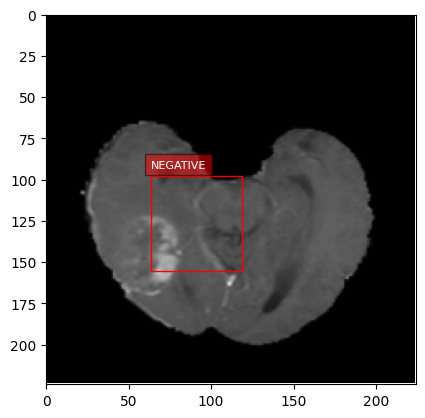

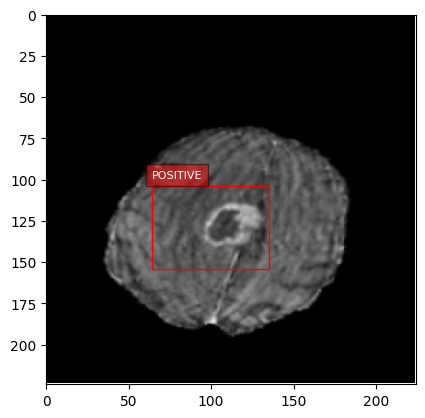

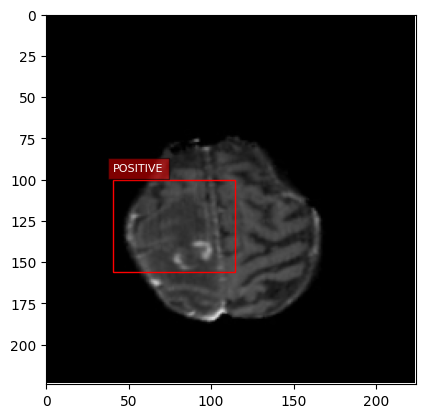

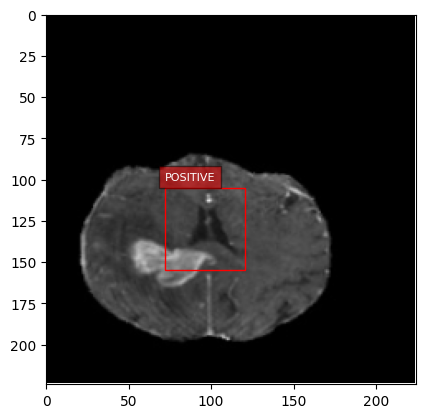

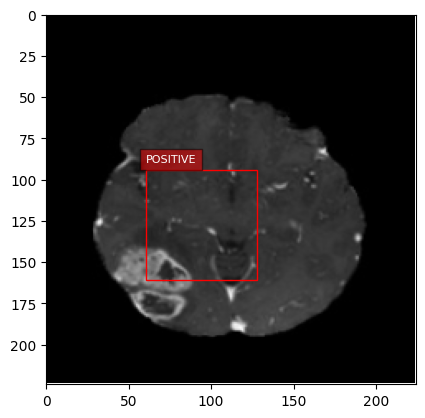

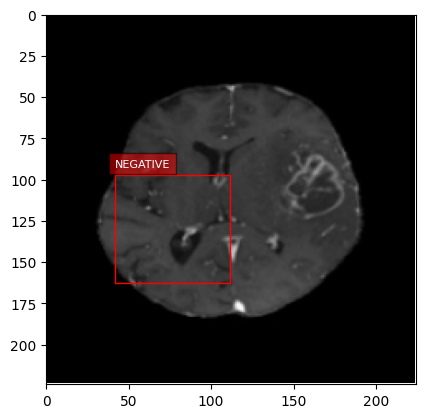

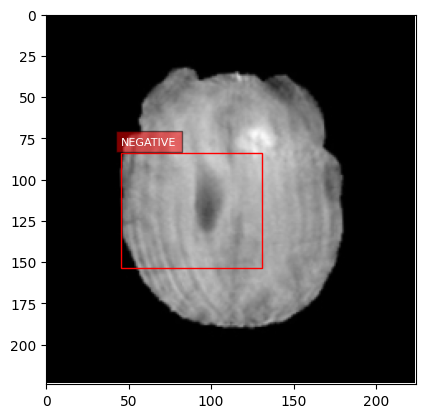

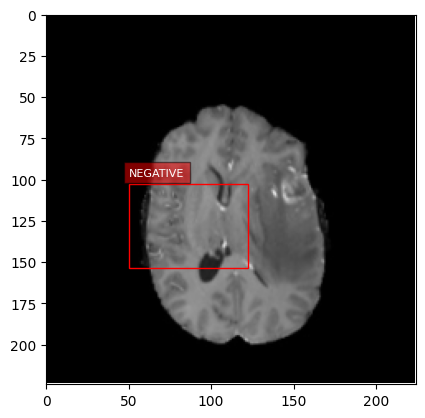

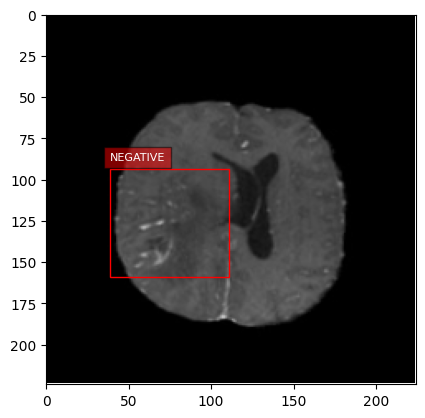

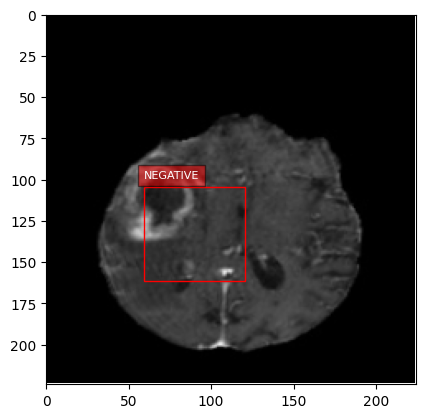

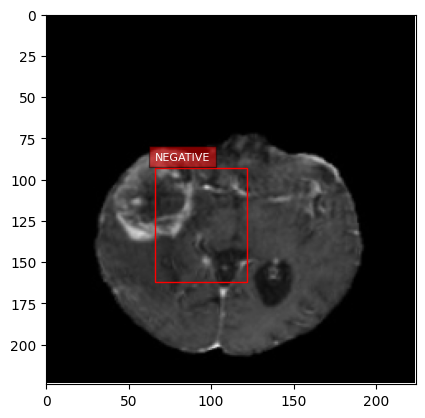

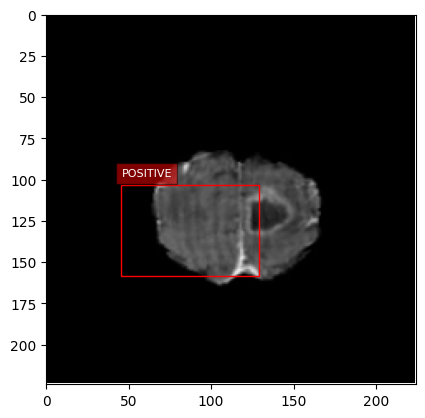

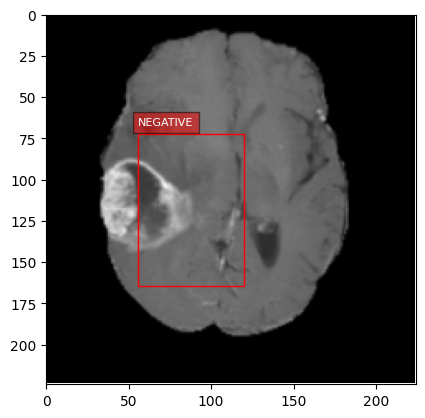

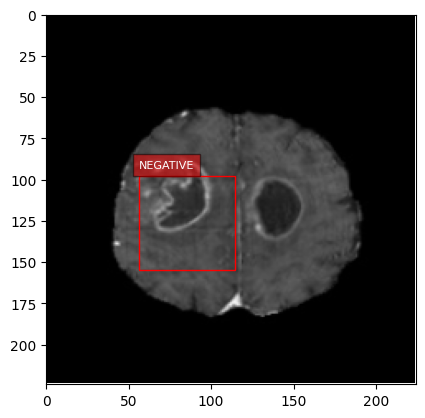

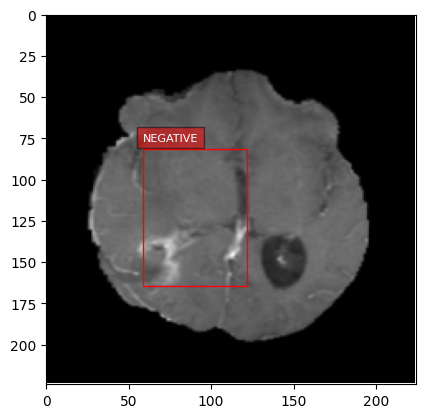

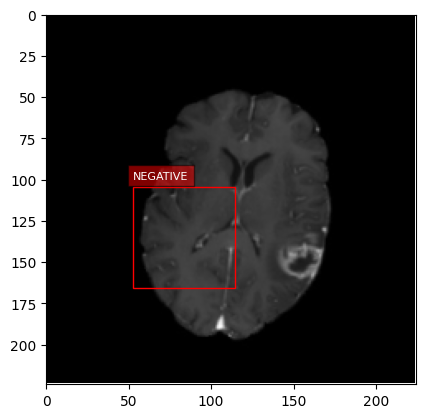

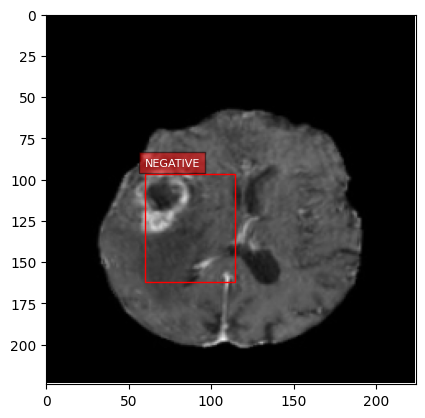

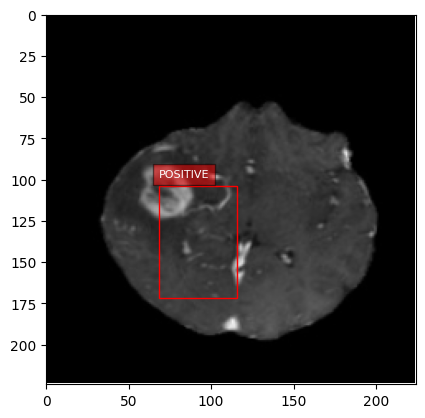

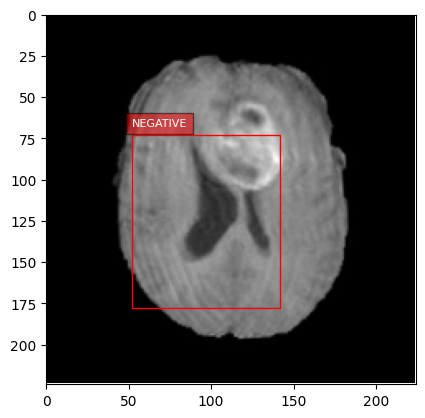

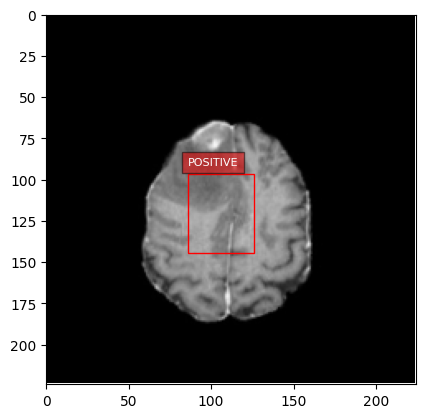

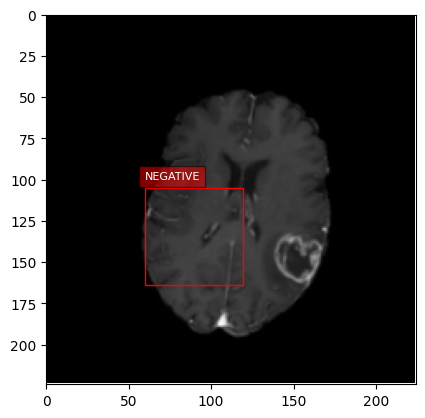

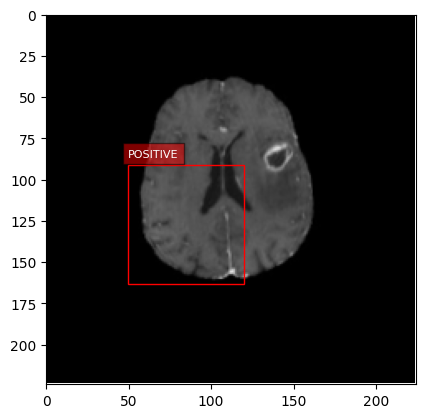

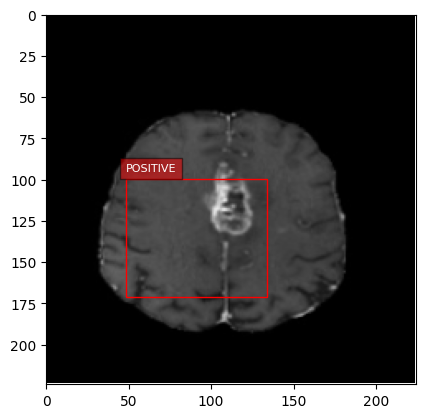

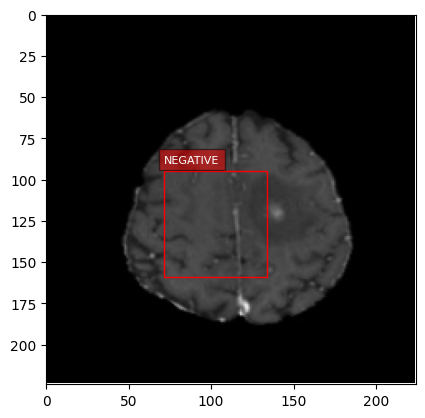

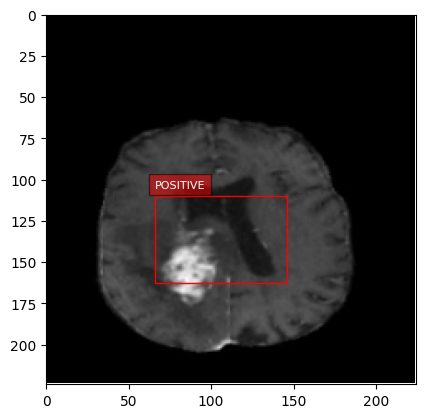

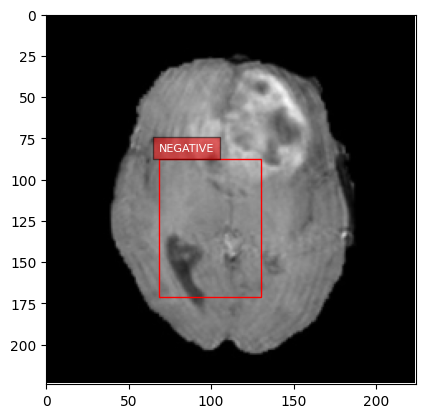

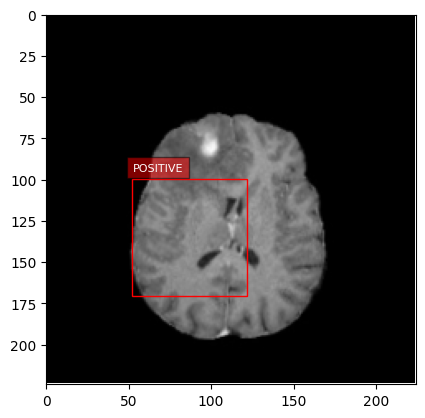

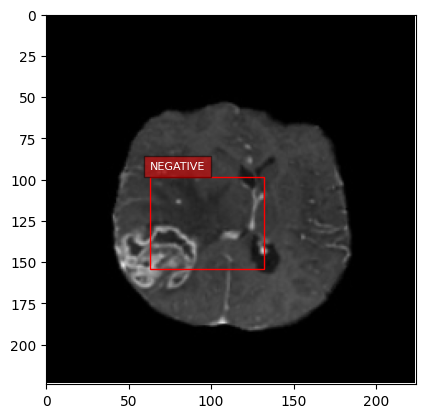

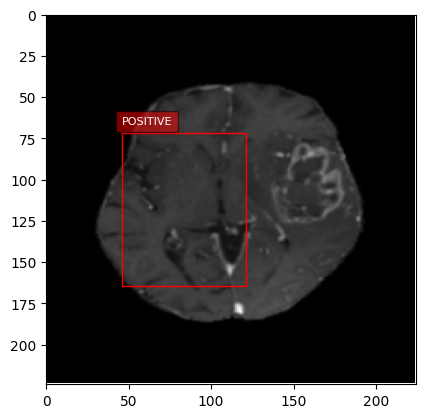

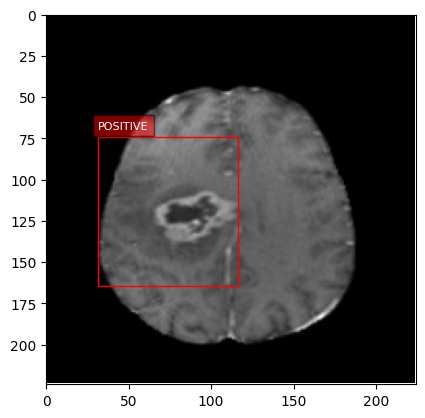

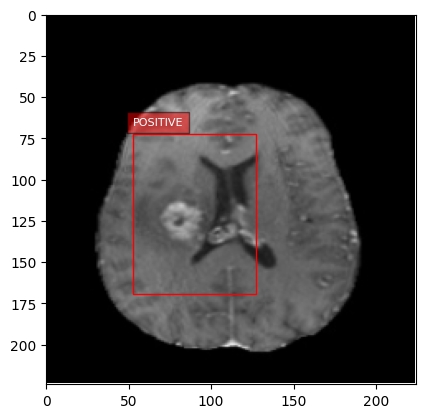

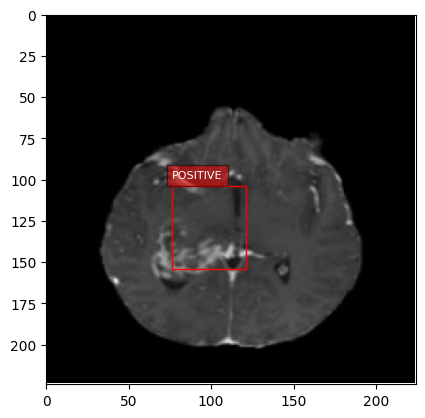

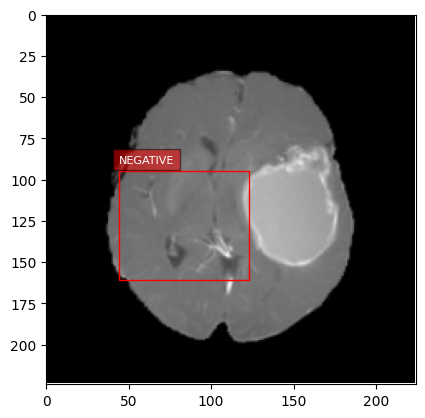

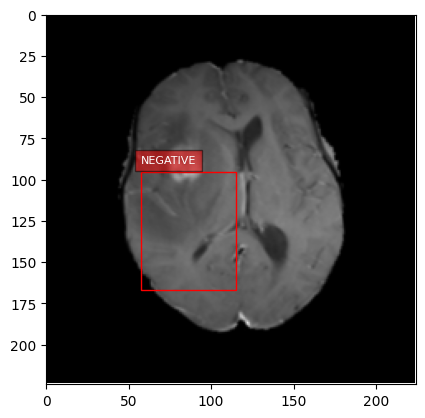

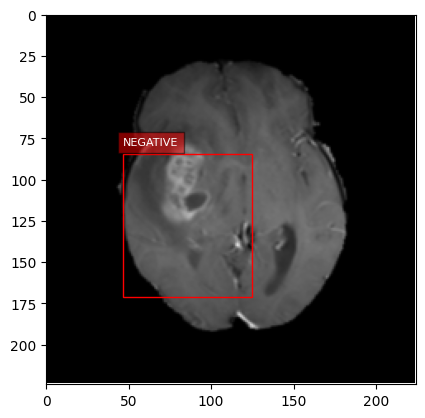

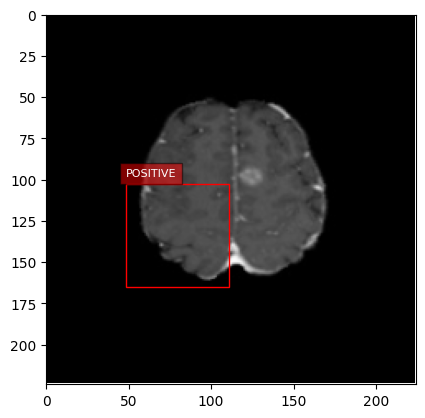

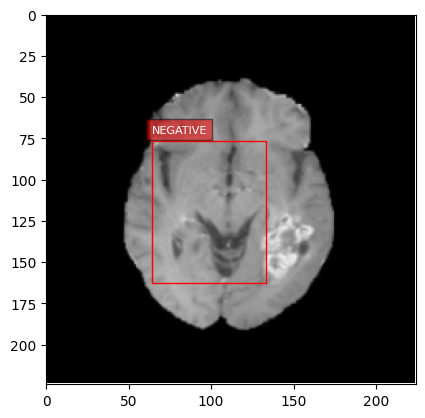

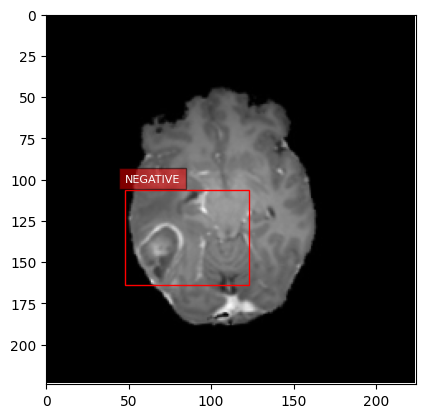

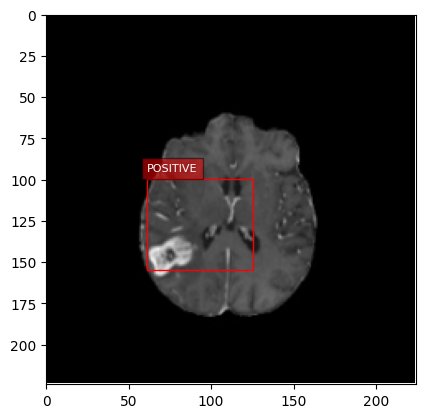

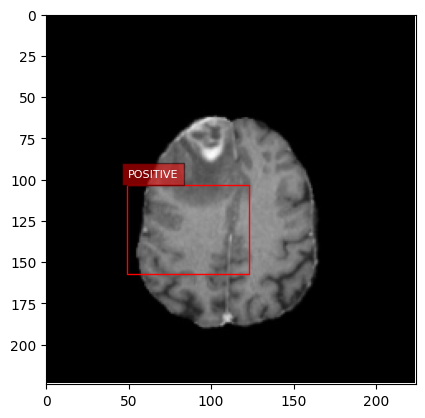

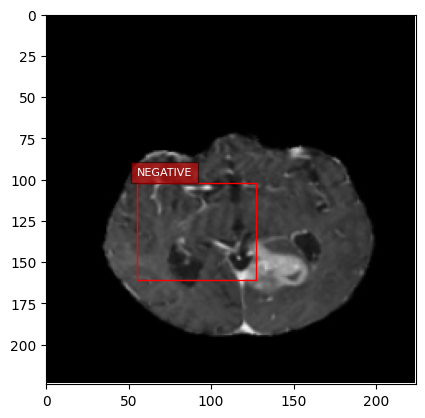

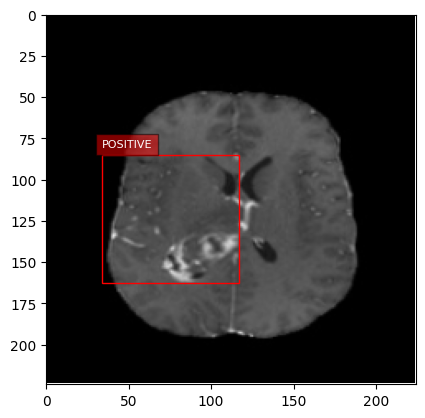

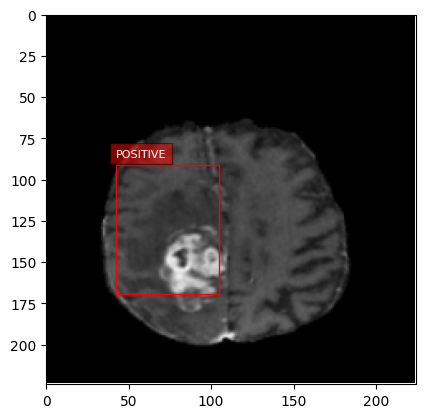

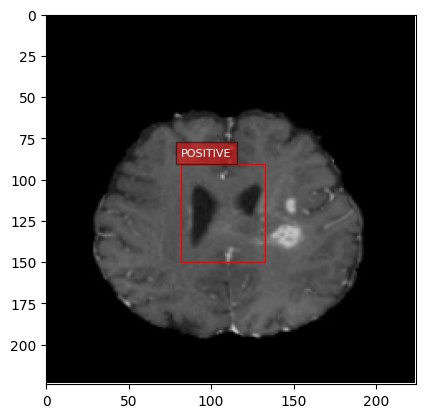

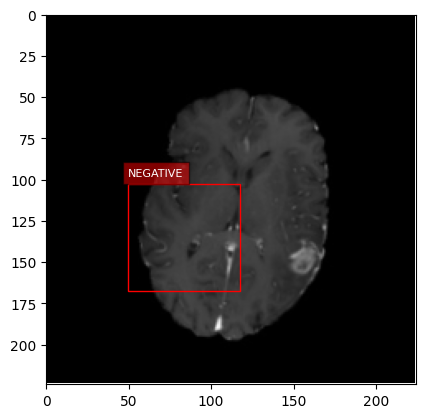

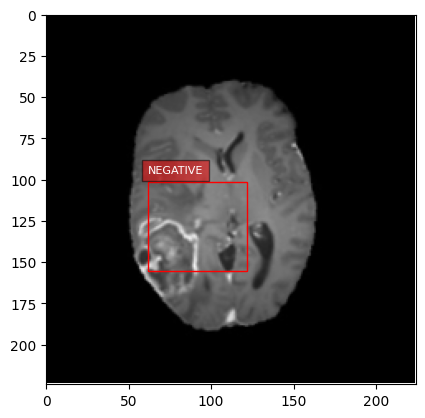

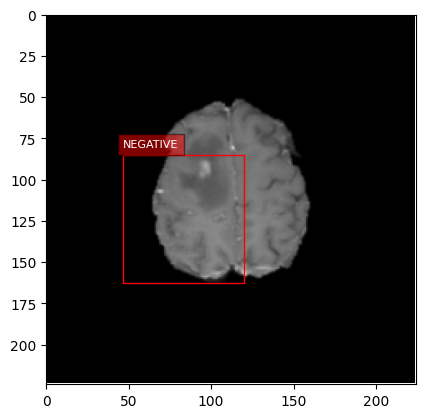

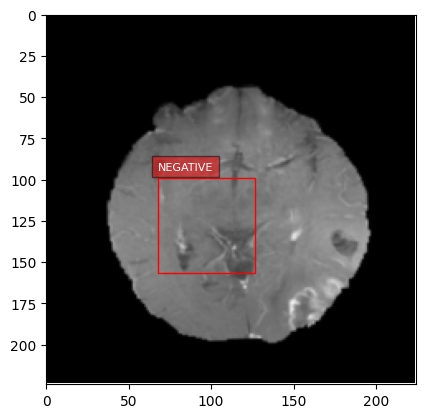

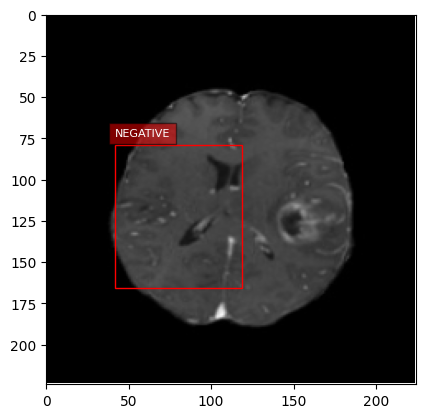

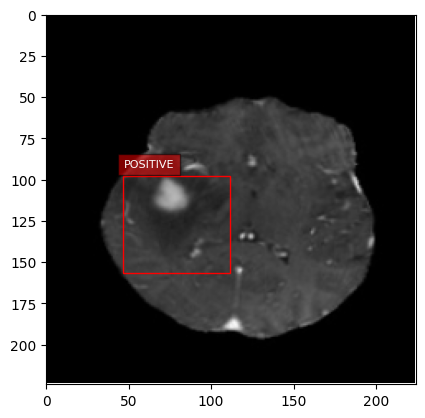

In [42]:
for i in range(50):
    inference(data[i]['image'])
    